In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import stats
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

In [2]:
skin_df = pd.read_csv('Ham\HAM10000_metadata.csv')
skin_df
SIZE=32

In [3]:

le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [4]:

skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))


        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

In [5]:
fig = plt.figure(figsize=(12,8))


<Figure size 1200x800 with 0 Axes>

Text(0.5, 1.0, 'Cell Type')

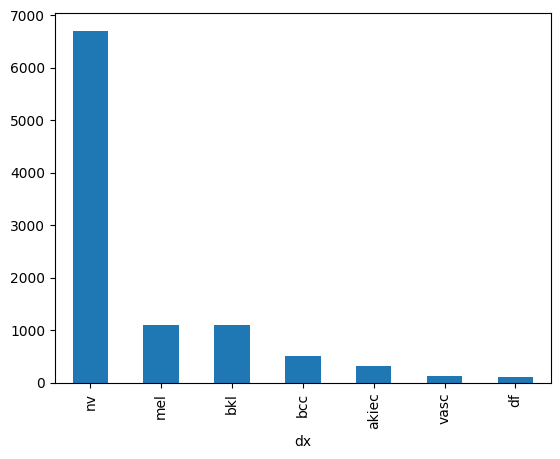

In [6]:
ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar')
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')

Text(0.5, 1.0, 'Sex')

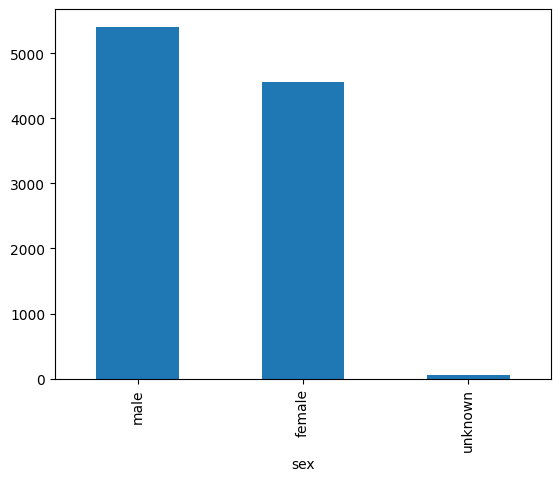

In [7]:
ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar')
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex')


Text(0.5, 1.0, 'Localization')

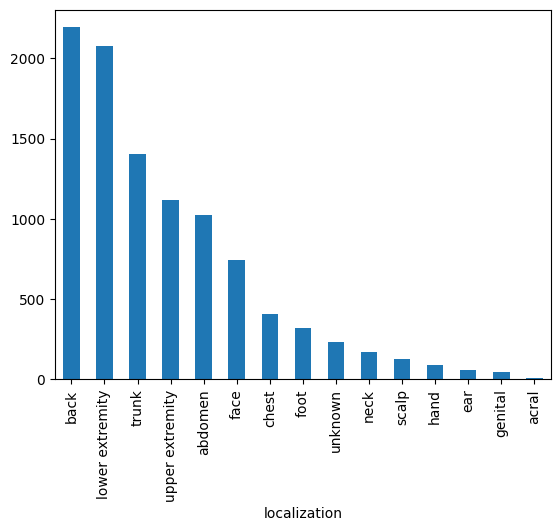

In [8]:
ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

C:\Users\pradeepan\AppData\Local\Temp\ipykernel_29320\3829969692.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


Text(0.5, 1.0, 'Age')

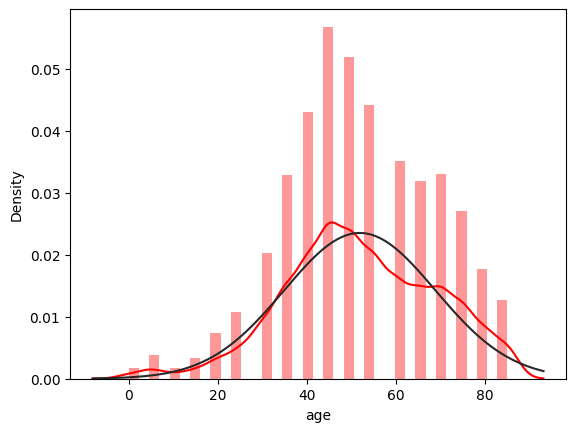

In [9]:
ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

In [10]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())



label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [11]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('Ham/', '*', '*.jpg'))}
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

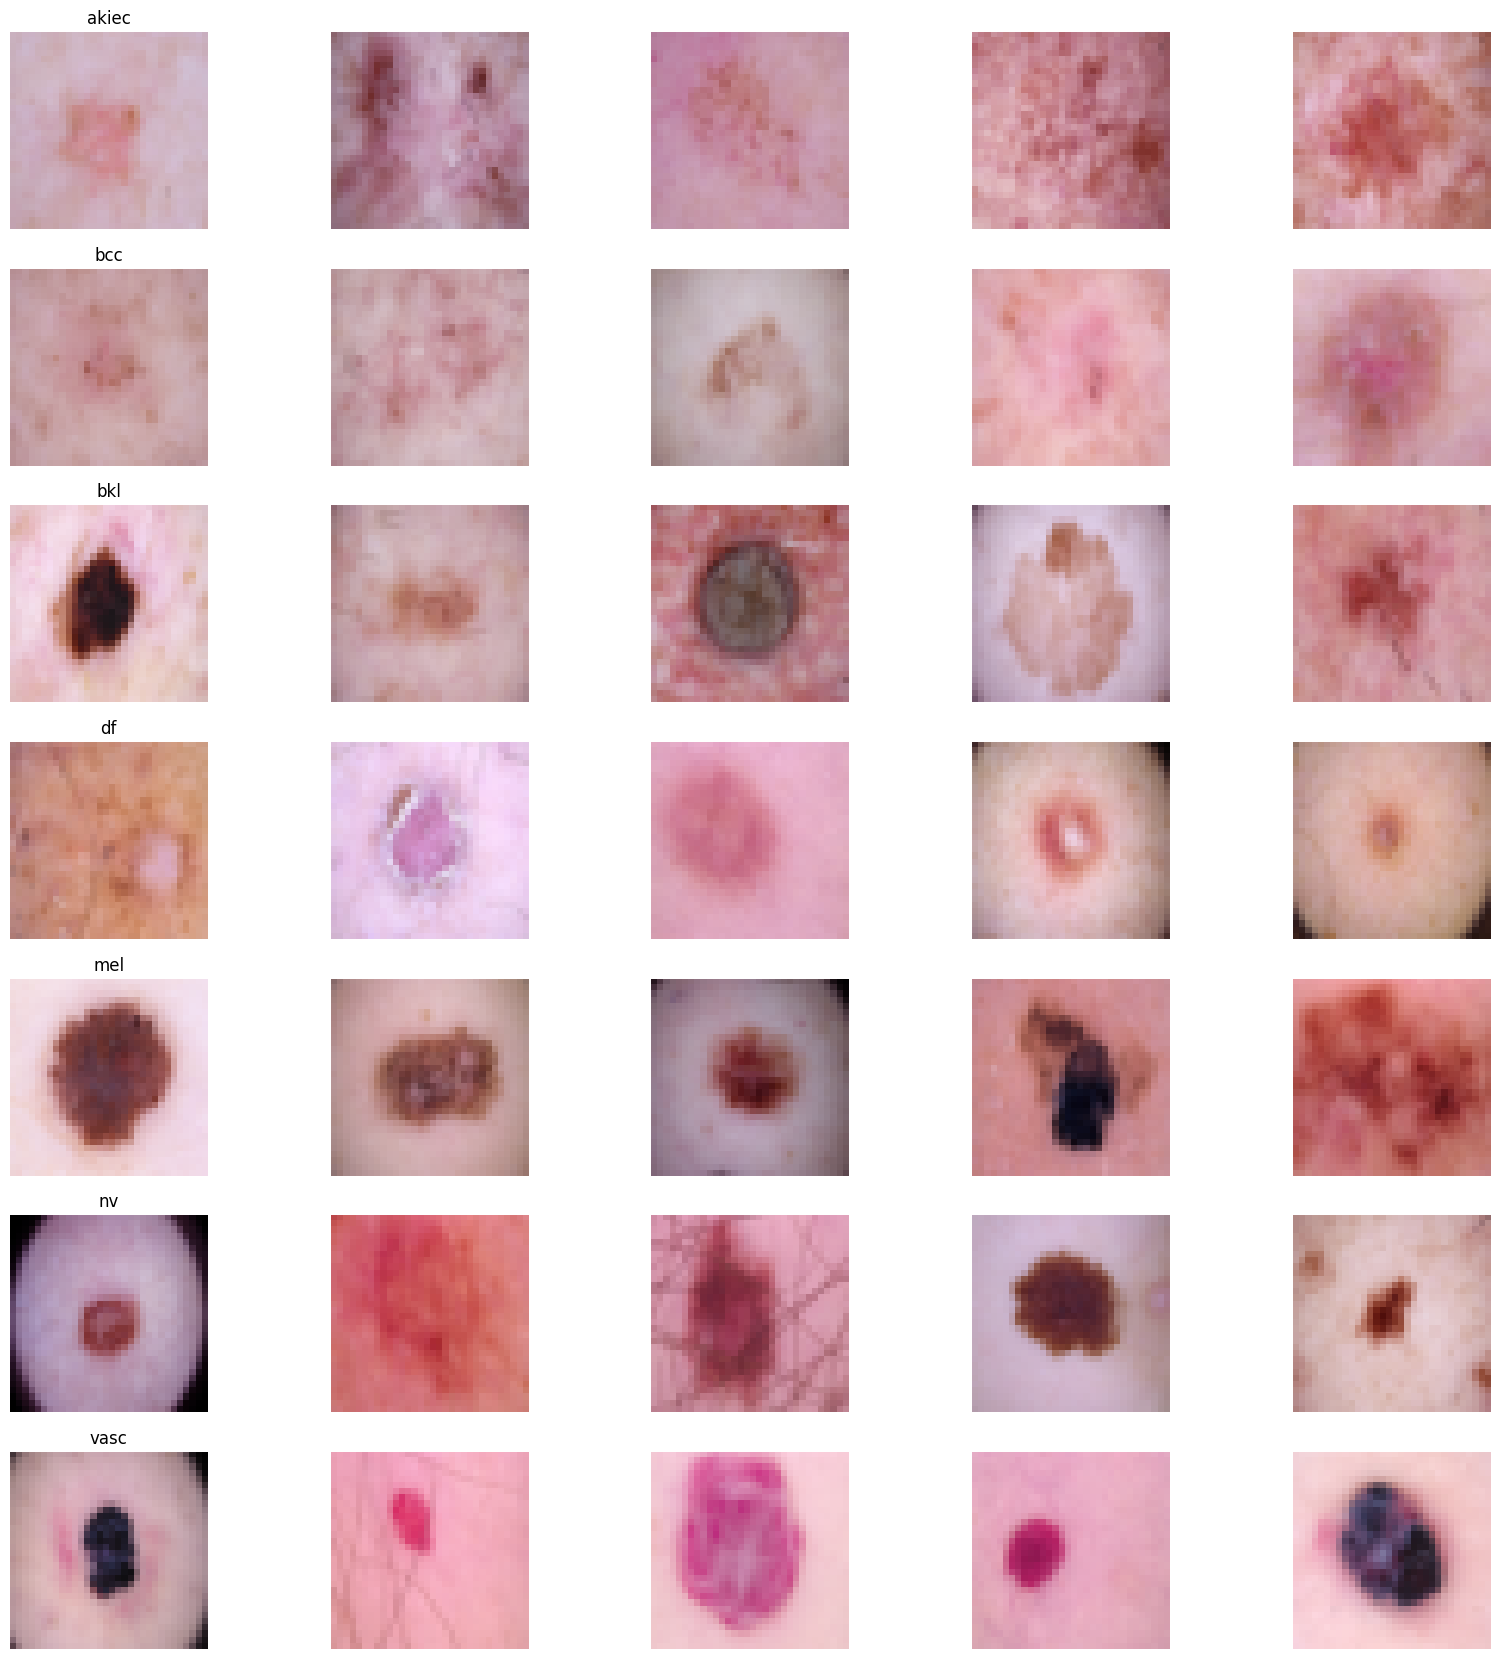

In [12]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [13]:
X = np.asarray(skin_df['image'].tolist())
X = X/255. 
Y=skin_df['label']  
Y_cat = to_categorical(Y, num_classes=7)
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.utils import to_categorical

# Assuming SIZE, x_train, y_train, x_test, y_test are already defined
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2
)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

c:\Users\pradeepan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
470/470 - 52s - 112ms/step - acc: 0.6700 - loss: 1.0279 - val_acc: 0.6661 - val_loss: 0.9454
Epoch 2/50
470/470 - 54s - 116ms/step - acc: 0.6734 - loss: 0.9463 - val_acc: 0.6733 - val_loss: 0.9149
Epoch 3/50
470/470 - 49s - 105ms/step - acc: 0.6793 - loss: 0.9119 - val_acc: 0.6873 - val_loss: 0.8868
Epoch 4/50
470/470 - 54s - 115ms/step - acc: 0.6879 - loss: 0.8754 - val_acc: 0.6849 - val_loss: 0.9726
Epoch 5/50
470/470 - 36s - 76ms/step - acc: 0.6915 - loss: 0.8441 - val_acc: 0.7001 - val_loss: 0.8485
Epoch 6/50
470/470 - 26s - 56ms/step - acc: 0.7008 - loss: 0.8281 - val_acc: 0.7041 - val_loss: 0.8180
Epoch 7/50
470/470 - 28s - 59ms/step - acc: 0.7086 - loss: 0.8063 - val_acc: 0.7093 - val_loss: 0.8071
Epoch 8/50
470/470 - 27s - 57ms/step - acc: 0.7110 - loss: 0.7913 - val_acc: 0.6953 - val_loss: 0.8746
Epoch 9/50
470/470 - 26s - 56ms/step - acc: 0.7161 - loss: 0.7755 - val_acc: 0.7133 - val_loss: 0.7815
Epoch 10/50
470/470 - 27s - 57ms/step - acc: 0.7176 - loss: 0.7662 - 

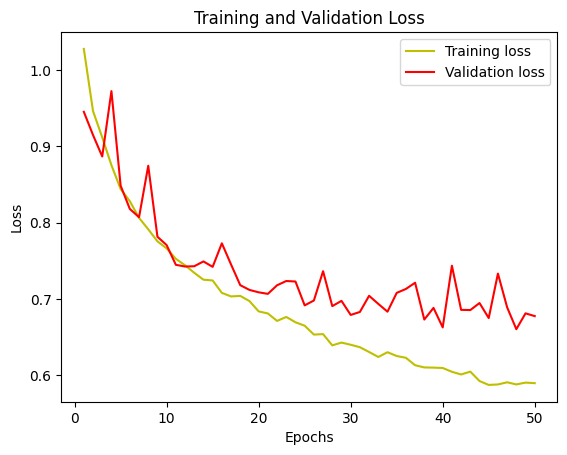

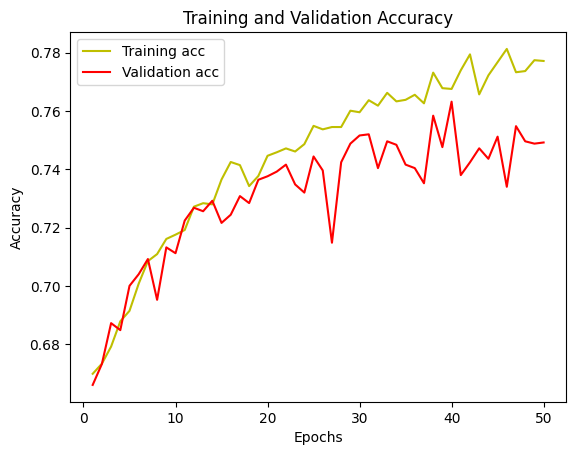

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


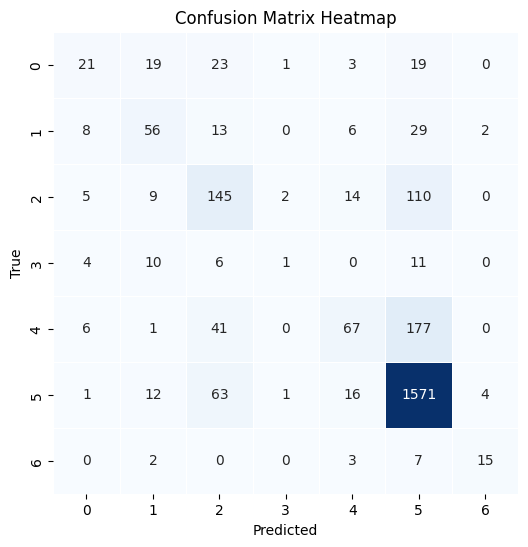

[[  21   19   23    1    3   19    0]
 [   8   56   13    0    6   29    2]
 [   5    9  145    2   14  110    0]
 [   4   10    6    1    0   11    0]
 [   6    1   41    0   67  177    0]
 [   1   12   63    1   16 1571    4]
 [   0    2    0    0    3    7   15]]


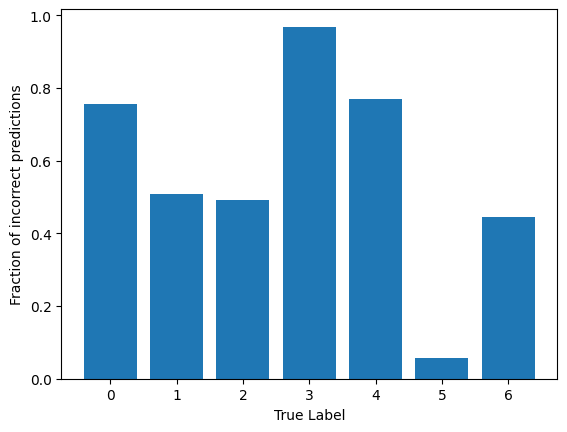

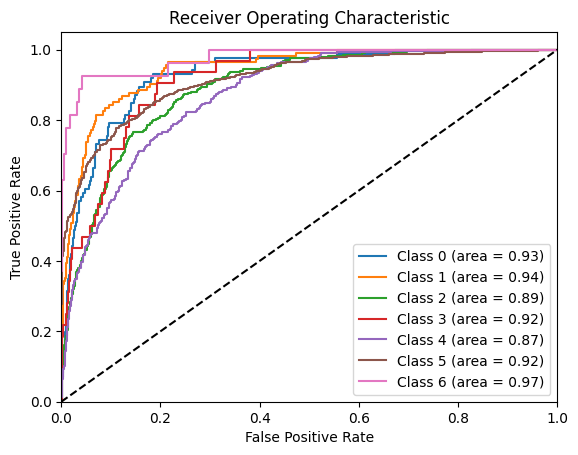

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

# Plotting Cross Entropy Loss
plt.figure()
plt.plot(epochs_range, loss, 'y', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']

# Plotting Training and Validation Accuracy
plt.figure()
plt.plot(epochs_range, acc, 'y', label='Training acc')
plt.plot(epochs_range, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", linewidths=.5, ax=ax, cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()
print(cm)

# Fraction of incorrect predictions
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(num_classes), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.show()

# ROC Curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical

# Assuming SIZE, x_train, y_train, x_test, y_test are already defined
num_classes = 7

model1 = Sequential()
model1.add(Conv2D(256, (3, 3), input_shape=(SIZE, SIZE, 3)))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPool2D(pool_size=(2, 2)))  
model1.add(Dropout(0.3))

model1.add(Conv2D(128, (3, 3)))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPool2D(pool_size=(2, 2)))  
model1.add(Dropout(0.3))

model1.add(Conv2D(64, (3, 3)))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPool2D(pool_size=(2, 2)))  
model1.add(Dropout(0.3))

model1.add(Flatten())
model1.add(Dense(32))
model1.add(LeakyReLU(alpha=0.1))
model1.add(Dense(num_classes, activation='softmax'))
model1.summary()

model1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

epochs = 50  # or any integer value
batch_size = 32  # or any integer value

history1 = model1.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2
)

score1 = model1.evaluate(x_test, y_test)
print('Test accuracy:', score1[1])

c:\Users\pradeepan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\pradeepan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
235/235 - 66s - 282ms/step - acc: 0.6680 - loss: 1.0341 - val_acc: 0.6713 - val_loss: 0.9135
Epoch 2/50
235/235 - 63s - 267ms/step - acc: 0.6811 - loss: 0.9304 - val_acc: 0.6909 - val_loss: 0.9365
Epoch 3/50
235/235 - 50s - 214ms/step - acc: 0.6885 - loss: 0.8919 - val_acc: 0.6981 - val_loss: 0.8941
Epoch 4/50
235/235 - 45s - 192ms/step - acc: 0.6871 - loss: 0.8601 - val_acc: 0.6917 - val_loss: 0.8820
Epoch 5/50
235/235 - 45s - 191ms/step - acc: 0.6988 - loss: 0.8295 - val_acc: 0.7045 - val_loss: 0.8107
Epoch 6/50
235/235 - 45s - 193ms/step - acc: 0.7088 - loss: 0.7997 - val_acc: 0.7057 - val_loss: 0.8067
Epoch 7/50
235/235 - 46s - 194ms/step - acc: 0.7079 - loss: 0.7932 - val_acc: 0.7157 - val_loss: 0.7962
Epoch 8/50
235/235 - 48s - 204ms/step - acc: 0.7159 - loss: 0.7707 - val_acc: 0.7204 - val_loss: 0.7678
Epoch 9/50
235/235 - 50s - 213ms/step - acc: 0.7225 - loss: 0.7511 - val_acc: 0.7173 - val_loss: 0.7504
Epoch 10/50
235/235 - 50s - 211ms/step - acc: 0.7271 - loss: 0.7

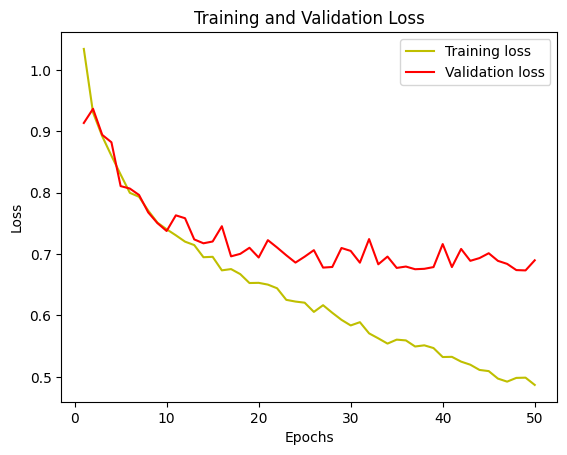

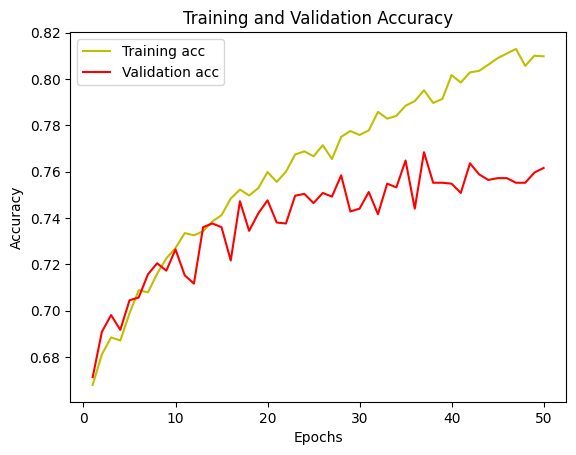

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


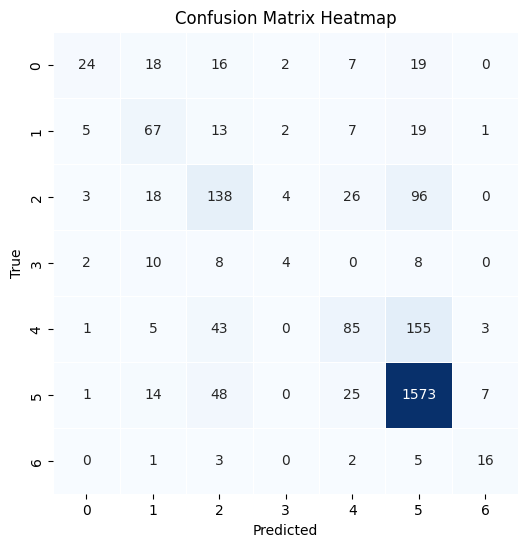

[[  24   18   16    2    7   19    0]
 [   5   67   13    2    7   19    1]
 [   3   18  138    4   26   96    0]
 [   2   10    8    4    0    8    0]
 [   1    5   43    0   85  155    3]
 [   1   14   48    0   25 1573    7]
 [   0    1    3    0    2    5   16]]


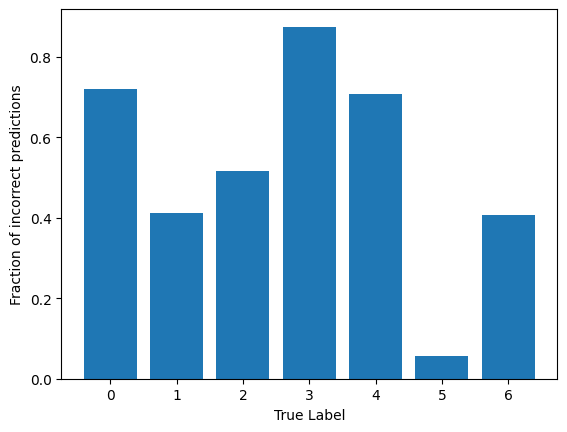

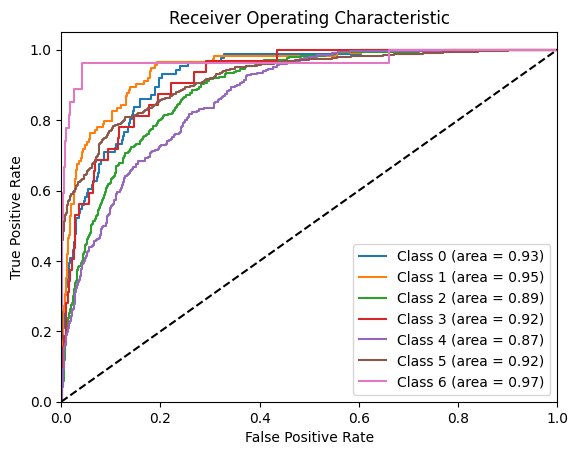

In [18]:
# Plotting Training and Validation Loss
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs_range, loss, 'y', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy
acc = history1.history['acc']
val_acc = history1.history['val_acc']

plt.figure()
plt.plot(epochs_range, acc, 'y', label='Training acc')
plt.plot(epochs_range, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred1 = model1.predict(x_test)
y_pred_classes1 = np.argmax(y_pred1, axis=1)
y_true = np.argmax(y_test, axis=1)
cm1 = confusion_matrix(y_true, y_pred_classes1)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm1, cmap="Blues", annot=True, fmt="d", linewidths=.5, ax=ax, cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()
print(cm1)

# Fraction of incorrect predictions
incorr_fraction1 = 1 - np.diag(cm1) / np.sum(cm1, axis=1)
plt.bar(np.arange(num_classes), incorr_fraction1)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.show()

# ROC Curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation
import tensorflow as tf

# Assuming SIZE, x_train, y_train, x_test, y_test are already defined
num_classes = 7

model3 = Sequential()
model3.add(Conv2D(256, (3, 3), input_shape=(SIZE, SIZE, 3)))
model3.add(Activation(tf.nn.swish))
model3.add(MaxPool2D(pool_size=(2, 2)))  
model3.add(Dropout(0.3))

model3.add(Conv2D(128, (3, 3)))
model3.add(Activation(tf.nn.swish))
model3.add(MaxPool2D(pool_size=(2, 2)))  
model3.add(Dropout(0.3))

model3.add(Conv2D(64, (3, 3)))
model3.add(Activation(tf.nn.swish))
model3.add(MaxPool2D(pool_size=(2, 2)))  
model3.add(Dropout(0.3))

model3.add(Flatten())
model3.add(Dense(32))
model3.add(Activation(tf.nn.swish))
model3.add(Dense(num_classes, activation='softmax'))
model3.summary()

model3.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

epochs = 50  # or any integer value
batch_size = 32  # or any integer value

history3 = model3.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2
)

score3 = model3.evaluate(x_test, y_test)
print('Test accuracy:', score3[1])

c:\Users\pradeepan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
235/235 - 59s - 250ms/step - acc: 0.6681 - loss: 1.0239 - val_acc: 0.6729 - val_loss: 0.9111
Epoch 2/50
235/235 - 38s - 162ms/step - acc: 0.6814 - loss: 0.9179 - val_acc: 0.6885 - val_loss: 0.8831
Epoch 3/50
235/235 - 40s - 172ms/step - acc: 0.6925 - loss: 0.8704 - val_acc: 0.6893 - val_loss: 0.8799
Epoch 4/50
235/235 - 37s - 158ms/step - acc: 0.6990 - loss: 0.8318 - val_acc: 0.7085 - val_loss: 0.7966
Epoch 5/50
235/235 - 37s - 158ms/step - acc: 0.7124 - loss: 0.7897 - val_acc: 0.7009 - val_loss: 0.7762
Epoch 6/50
235/235 - 37s - 159ms/step - acc: 0.7225 - loss: 0.7617 - val_acc: 0.7153 - val_loss: 0.7511
Epoch 7/50
235/235 - 57s - 242ms/step - acc: 0.7287 - loss: 0.7410 - val_acc: 0.7165 - val_loss: 0.7395
Epoch 8/50
235/235 - 60s - 256ms/step - acc: 0.7384 - loss: 0.7177 - val_acc: 0.7268 - val_loss: 0.7672
Epoch 9/50
235/235 - 60s - 256ms/step - acc: 0.7337 - loss: 0.7245 - val_acc: 0.7240 - val_loss: 0.7302
Epoch 10/50
235/235 - 50s - 211ms/step - acc: 0.7448 - loss: 0.7

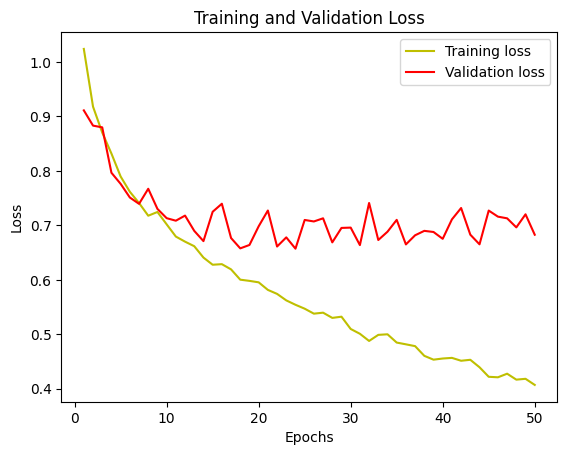

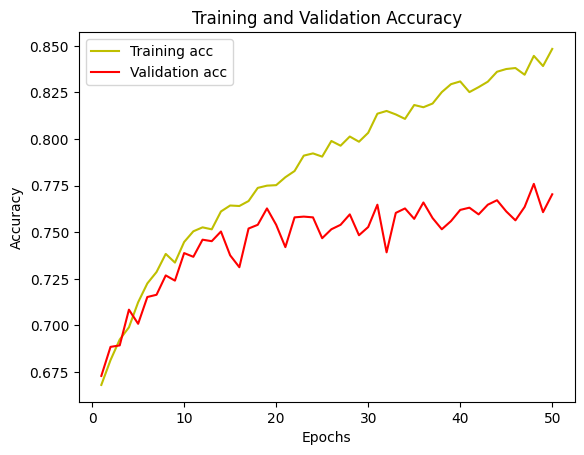

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step


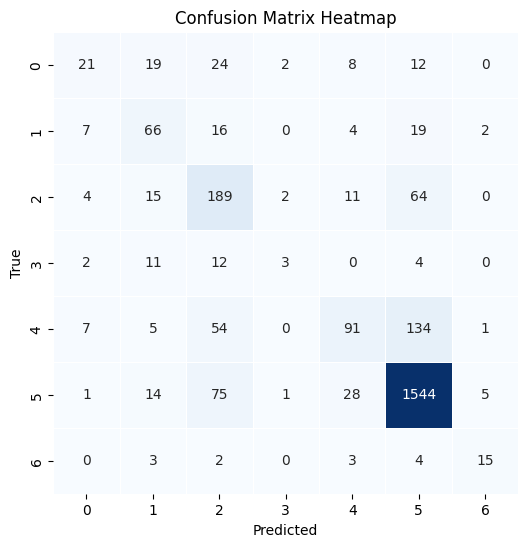

[[  21   19   24    2    8   12    0]
 [   7   66   16    0    4   19    2]
 [   4   15  189    2   11   64    0]
 [   2   11   12    3    0    4    0]
 [   7    5   54    0   91  134    1]
 [   1   14   75    1   28 1544    5]
 [   0    3    2    0    3    4   15]]


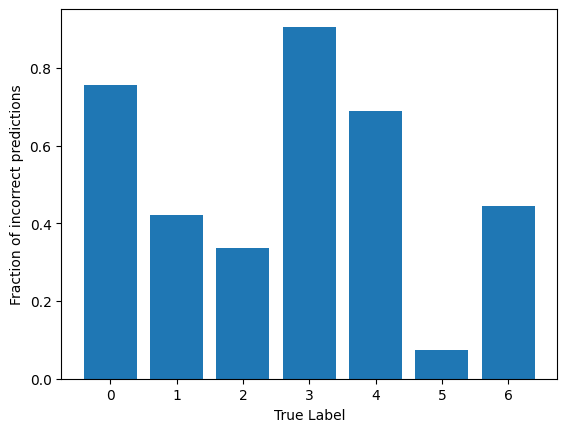

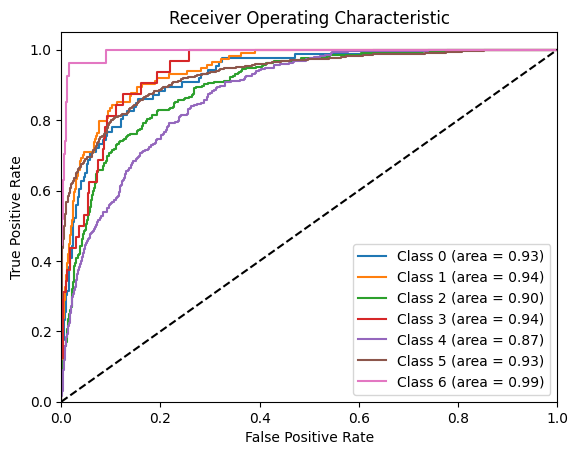

In [20]:
# Plotting Training and Validation Loss
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs_range, loss, 'y', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy
acc = history3.history['acc']
val_acc = history3.history['val_acc']

plt.figure()
plt.plot(epochs_range, acc, 'y', label='Training acc')
plt.plot(epochs_range, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred3 = model3.predict(x_test)
y_pred_classes3 = np.argmax(y_pred3, axis=1)
y_true = np.argmax(y_test, axis=1)
cm2 = confusion_matrix(y_true, y_pred_classes3)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm2, cmap="Blues", annot=True, fmt="d", linewidths=.5, ax=ax, cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()
print(cm2)

# Fraction of incorrect predictions
incorr_fraction2 = 1 - np.diag(cm2) / np.sum(cm2, axis=1)
plt.bar(np.arange(num_classes), incorr_fraction2)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.show()

# ROC Curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred3[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Activation
import tensorflow as tf

def create_adjusted_alexnet(input_shape, num_classes):
    model = Sequential()

    # Layer 1: Conv Layer
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Layer 2: Conv Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Layer 3: Conv Layer
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))

    # Layer 4: Conv Layer
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))

    # Layer 5: Conv Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(BatchNormalization())

    # Flatten the output
    model.add(Flatten())

    # Layer 6: Fully Connected Layer
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Layer 7: Fully Connected Layer
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Layer 8: Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Input shape and number of classes
input_shape = (32, 32, 3)  # Example input shape for AlexNet
num_classes = 7  # Number of output classes (adjust based on your dataset)

# Create the model
alexnet_model = create_adjusted_alexnet(input_shape=input_shape, num_classes=num_classes)

# Compile the model
alexnet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

# Display the model summary
alexnet_model.summary()

# Assuming you have already defined x_train, y_train, x_test, and y_test

# epochs and batch_size
epochs = 50
batch_size = 32

# Train the model
history = alexnet_model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2
)

# Evaluate the model
score = alexnet_model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

c:\Users\pradeepan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,883,783 (14.82 MB)

 Trainable params: 3,883,143 (14.81 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
235/235 - 89s - 377ms/step - acc: 0.6436 - loss: 1.0920 - val_acc: 0.1142 - val_loss: 2.0495
Epoch 2/50
235/235 - 53s - 226ms/step - acc: 0.6833 - loss: 0.9041 - val_acc: 0.6422 - val_loss: 1.0931
Epoch 3/50
235/235 - 38s - 163ms/step - acc: 0.6918 - loss: 0.8713 - val_acc: 0.6765 - val_loss: 0.8631
Epoch 4/50
235/235 - 36s - 154ms/step - acc: 0.7124 - loss: 0.8058 - val_acc: 0.2688 - val_loss: 1.6831
Epoch 5/50
235/235 - 36s - 155ms/step - acc: 0.7161 - loss: 0.7753 - val_acc: 0.7073 - val_loss: 0.9162
Epoch 6/50
235/235 - 37s - 158ms/step - acc: 0.7233 - loss: 0.7719 - val_acc: 0.6701 - val_loss: 1.1333
Epoch 7/50
235/235 - 36s - 154ms/step - acc: 0.7386 - loss: 0.7199 - val_acc: 0.5847 - val_loss: 1.1802
Epoch 8/50
235/235 - 37s - 158ms/step - acc: 0.7477 - loss: 0.7088 - val_acc: 0.7145 - val_loss: 0.7923
Epoch 9/50
235/235 - 41s - 176ms/step - acc: 0.7509 - loss: 0.6944 - val_acc: 0.6757 - val_loss: 0.9732
Epoch 10/50
235/235 - 48s - 206ms/step - acc: 0.7576 - loss: 0.6

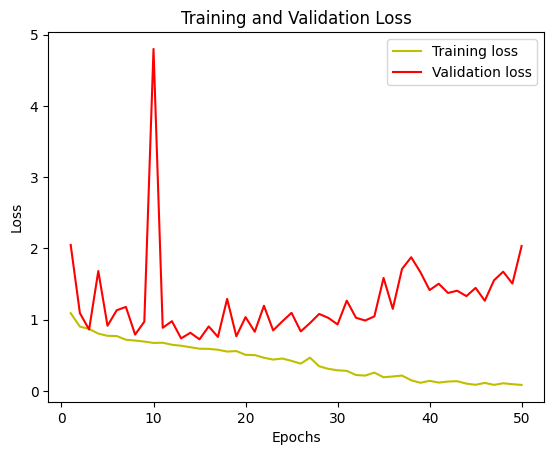

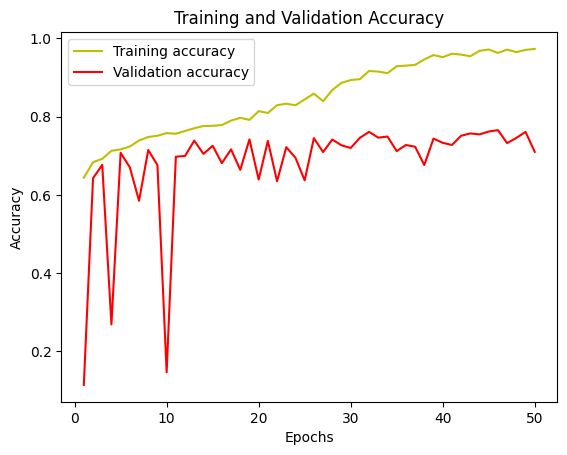

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


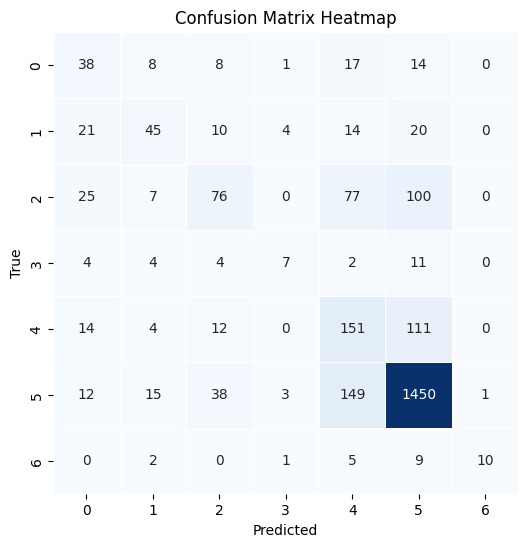

[[  38    8    8    1   17   14    0]
 [  21   45   10    4   14   20    0]
 [  25    7   76    0   77  100    0]
 [   4    4    4    7    2   11    0]
 [  14    4   12    0  151  111    0]
 [  12   15   38    3  149 1450    1]
 [   0    2    0    1    5    9   10]]


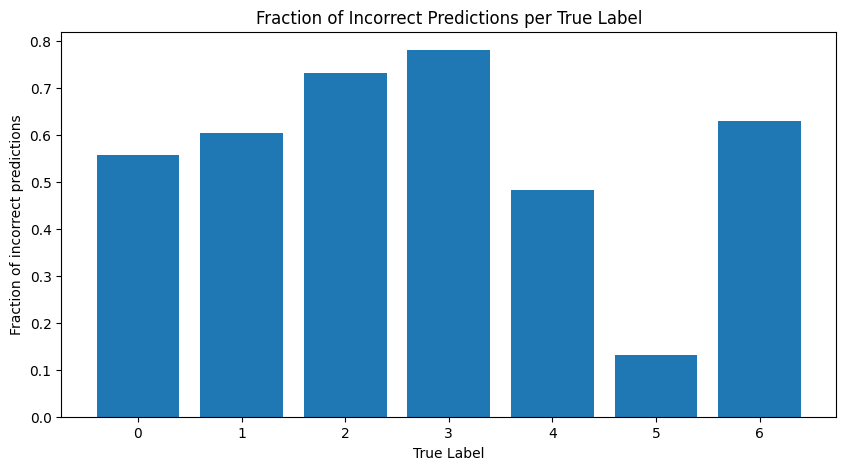

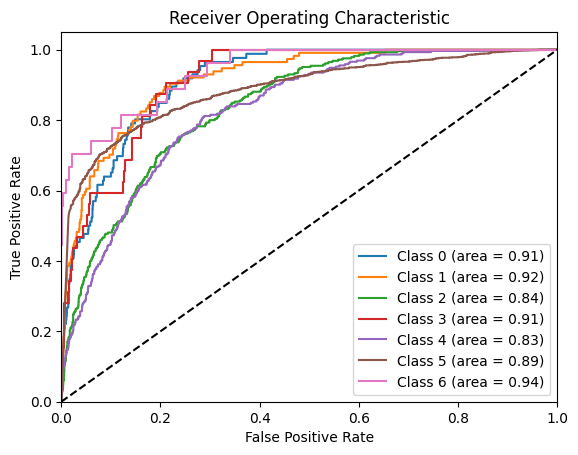

In [22]:

# Plotting Training and Validation Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs_range, loss, 'y', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure()
plt.plot(epochs_range, acc, 'y', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predictions
y_pred = alexnet_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm2 = confusion_matrix(y_true, y_pred_classes)

fig2, ax2 = plt.subplots(figsize=(6, 6))
sns.heatmap(cm2, cmap="Blues", annot=True, fmt="d", linewidths=.5, ax=ax2, cbar=False)  # Adjust the colormap as needed
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()
print(cm2)

# Fraction of incorrect predictions
incorr_fraction1 = 1 - np.diag(cm2) / np.sum(cm2, axis=1)
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(incorr_fraction1)), incorr_fraction1)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.title('Fraction of Incorrect Predictions per True Label')
plt.show()

# ROC Curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Activation
import tensorflow as tf

def create_lenet_variant(input_shape=(32, 32, 3), num_classes=7):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(6, (5, 5), padding='same', input_shape=input_shape))
    model.add(Activation(tf.nn.swish))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second Convolutional Layer
    model.add(Conv2D(16, (5, 5), padding='valid'))
    model.add(Activation(tf.nn.swish))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Flatten the output
    model.add(Flatten())

    # First Fully Connected Layer
    model.add(Dense(120))
    model.add(Activation(tf.nn.swish))
    model.add(Dropout(0.3))

    # Second Fully Connected Layer
    model.add(Dense(84))
    model.add(Activation(tf.nn.swish))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Input shape and number of classes
input_shape = (32, 32, 3)  # Example input shape (can be adjusted)
num_classes = 7  # Number of output classes

# Create the model
lenet_variant_model = create_lenet_variant(input_shape=input_shape, num_classes=num_classes)

# Compile the model
lenet_variant_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

# Display the model summary
lenet_variant_model.summary()

# Assuming you have already defined x_train, y_train, x_test, and y_test
# epochs and batch_size
epochs = 50
batch_size = 32

# Train the model
history = lenet_variant_model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2
)

# Evaluate the model
score = lenet_variant_model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


c:\Users\pradeepan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 32, 32, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 120)            │        69,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           595 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,871 (323.71 KB)

 Trainable params: 82,871 (323.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
235/235 - 9s - 37ms/step - acc: 0.6674 - loss: 1.1266 - val_acc: 0.6649 - val_loss: 0.9951
Epoch 2/50
235/235 - 2s - 10ms/step - acc: 0.6706 - loss: 0.9781 - val_acc: 0.6629 - val_loss: 0.9517
Epoch 3/50
235/235 - 2s - 10ms/step - acc: 0.6723 - loss: 0.9326 - val_acc: 0.6769 - val_loss: 0.8913
Epoch 4/50
235/235 - 2s - 10ms/step - acc: 0.6806 - loss: 0.9092 - val_acc: 0.6809 - val_loss: 0.8921
Epoch 5/50
235/235 - 2s - 10ms/step - acc: 0.6883 - loss: 0.9006 - val_acc: 0.6949 - val_loss: 0.8617
Epoch 6/50
235/235 - 2s - 10ms/step - acc: 0.6923 - loss: 0.8753 - val_acc: 0.6957 - val_loss: 0.8233
Epoch 7/50
235/235 - 2s - 10ms/step - acc: 0.6971 - loss: 0.8472 - val_acc: 0.6937 - val_loss: 0.8542
Epoch 8/50
235/235 - 3s - 11ms/step - acc: 0.7075 - loss: 0.8137 - val_acc: 0.7173 - val_loss: 0.7667
Epoch 9/50
235/235 - 2s - 10ms/step - acc: 0.7096 - loss: 0.8030 - val_acc: 0.7065 - val_loss: 0.8114
Epoch 10/50
235/235 - 2s - 10ms/step - acc: 0.7205 - loss: 0.7809 - val_acc: 0.722

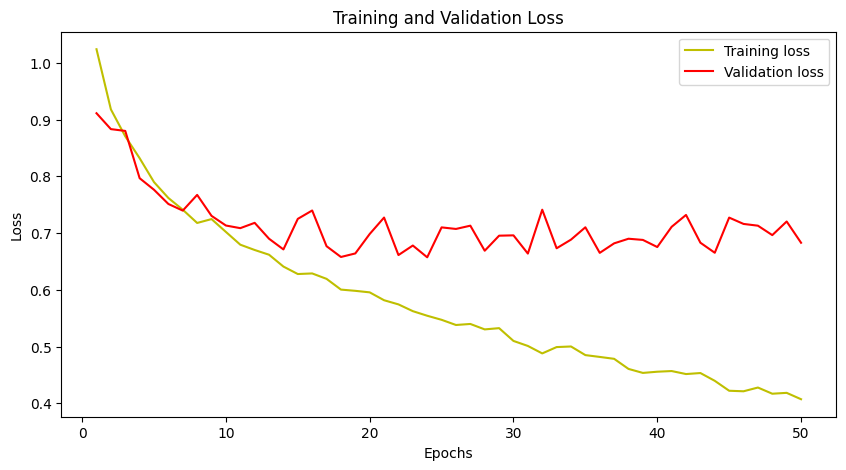

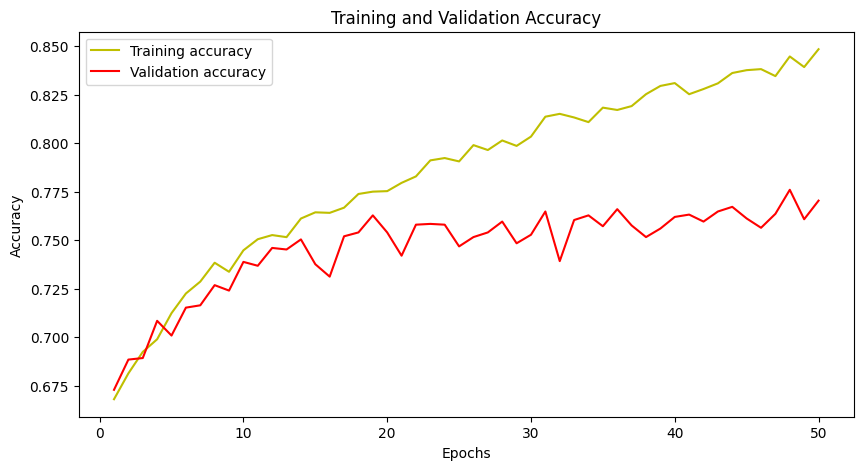

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


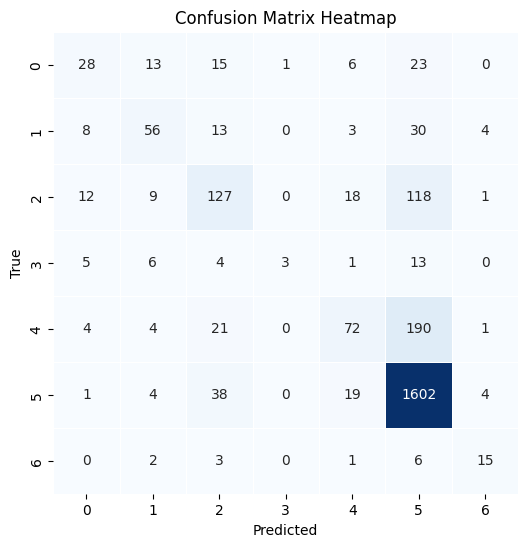

[[  28   13   15    1    6   23    0]
 [   8   56   13    0    3   30    4]
 [  12    9  127    0   18  118    1]
 [   5    6    4    3    1   13    0]
 [   4    4   21    0   72  190    1]
 [   1    4   38    0   19 1602    4]
 [   0    2    3    0    1    6   15]]


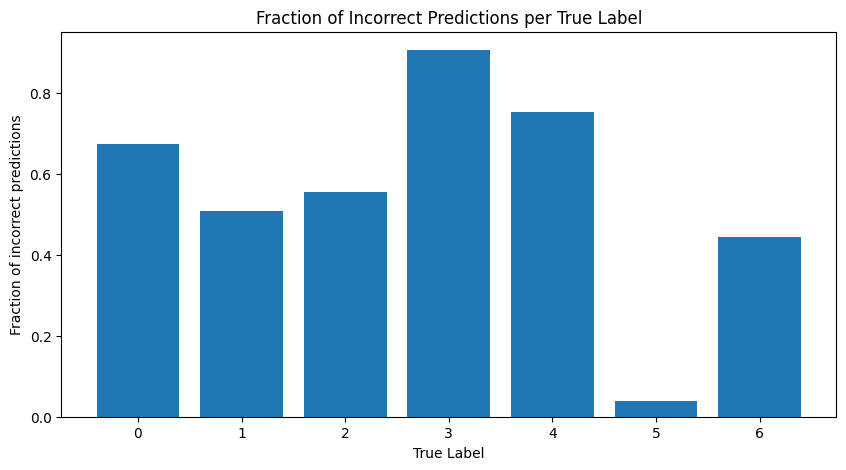

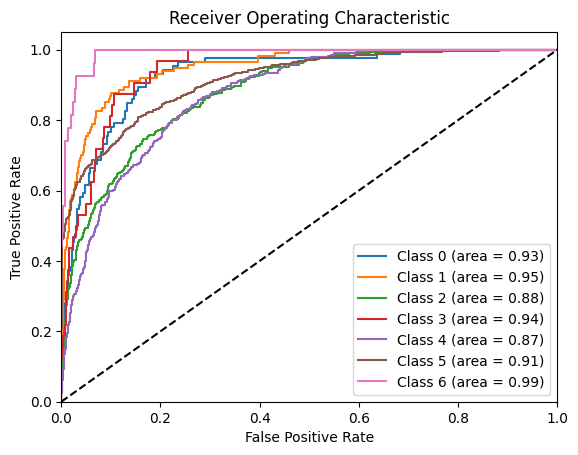

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Assuming you have already trained your LeNet model and have the history
# Replace `history3` with the history variable from the training of the LeNet model
history = history3  # Replace with the actual history object if different

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predictions
y_pred = lenet_variant_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm2 = confusion_matrix(y_true, y_pred_classes)

fig2, ax2 = plt.subplots(figsize=(6, 6))
sns.heatmap(cm2, cmap="Blues", annot=True, fmt="d", linewidths=.5, ax=ax2, cbar=False)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()
print(cm2)

# Fraction of incorrect predictions
incorr_fraction1 = 1 - np.diag(cm2) / np.sum(cm2, axis=1)
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(incorr_fraction1)), incorr_fraction1)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.title('Fraction of Incorrect Predictions per True Label')
plt.show()

# ROC Curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
